#[01] GRU

##(1) data loading & tokenizing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import torch
import urllib.request
from tqdm import tqdm
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/pytorch-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/IMDB%20Dataset.csv",
                           filename = "IMDB_Dataset.csv")

('IMDB_Dataset.csv', <http.client.HTTPMessage at 0x7ad140daa710>)

In [5]:
df = pd.read_csv('IMDB_Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
print('Missing value :', df.isna().values.any())

Missing value : False


<Axes: xlabel='sentiment'>

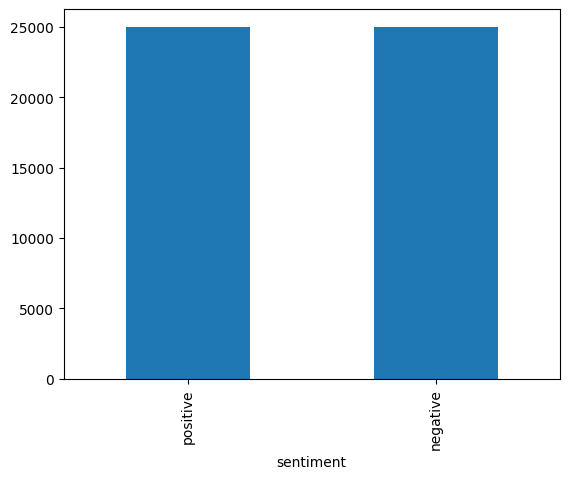

In [8]:
df['sentiment'].value_counts().plot(kind='bar')

In [9]:
print('Label Count')
print(df.groupby('sentiment').size().reset_index(name='count'))

Label Count
  sentiment  count
0  negative  25000
1  positive  25000


In [10]:
df['sentiment'] = df['sentiment'].replace(['positive', 'negative'], [1, 0])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [11]:
X_data = df['review']
y_data = df['sentiment']
print('Review Count: {}'.format(len(X_data)))
print('Label Count: {}'.format(len(y_data)))

Review Count: 50000
Label Count: 50000


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=0, stratify=y_data)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=0, stratify=y_train)

print('---------- Train Data Ratio -------------')
print(f'Negative Review = {round(y_train.value_counts()[0] / len(y_train) * 100, 3)} %')
print(f'Positive Review = {round(y_train.value_counts()[1] / len(y_train) * 100, 3)} %')
print('---------- Valid Data Ratio -------------')
print(f'Negative Review = {round(y_valid.value_counts()[0] / len(y_valid) * 100, 3)} %')
print(f'Positive Review = {round(y_valid.value_counts()[1] / len(y_valid) * 100, 3)} %')
print('---------- Test Data Ratio -------------')
print(f'Negative Review = {round(y_test.value_counts()[0] / len(y_test) * 100, 3)} %')
print(f'Positive Review = {round(y_test.value_counts()[1] / len(y_test) * 100, 3)} %')

---------- Train Data Ratio -------------
Negative Review = 50.0 %
Positive Review = 50.0 %
---------- Valid Data Ratio -------------
Negative Review = 50.0 %
Positive Review = 50.0 %
---------- Test Data Ratio -------------
Negative Review = 50.0 %
Positive Review = 50.0 %


In [13]:
def tokenize(sentences):
    tokenized_sentences = []
    for sent in sentences:
        tokenized_sent = word_tokenize(sent)
        tokenized_sent = [word.lower() for word in tokenized_sent]
        tokenized_sentences.append(tokenized_sent)
    return tokenized_sentences

tokenized_X_train = tokenize(X_train)
tokenized_X_valid = tokenize(X_valid)
tokenized_X_test = tokenize(X_test)

In [14]:
for sent in tokenized_X_train[:2]:
    print(sent)

['have', 'you', 'ever', ',', 'or', 'do', 'you', 'have', ',', 'a', 'pet', 'who', "'s", 'been', 'with', 'you', 'through', 'thick', 'and', 'thin', ',', 'who', 'you', "'d", 'be', 'lost', 'without', ',', 'and', 'who', 'you', 'love', 'no', 'matter', 'what', '?', 'betcha', 'never', 'thought', 'they', 'feel', 'the', 'same', 'way', 'about', 'you', '!', '<', 'br', '/', '>', '<', 'br', '/', '>', 'wonderful', ',', 'wonderful', 'family', 'film', '.', 'if', 'you', 'have', 'a', 'soft', 'spot', 'for', 'animals', ',', 'this', 'is', 'guaranteed', 'to', 'make', 'you', 'cry', 'no', 'matter', 'your', 'age', '.', 'i', 'used', 'to', 'watch', 'this', 'movie', 'all', 'the', 'time', 'when', 'i', 'was', 'a', 'little', 'kid', ',', 'and', 'i', 'find', 'that', 'now', ',', 'at', 'age', 'sixteen', ',', 'i', 'love', 'it', 'as', 'much', 'as', 'i', 'did', 'then', '.', 'i', 'could', 'never', 'decide', 'on', 'a', 'favorite', 'character', 'then', ',', 'and', 'i', 'still', 'do', "n't", 'think', 'i', 'can', '!', 'i', 'love',

##(2) Making Vocab

In [15]:
word_list = []
for sent in tokenized_X_train:
    for word in sent:
        word_list.append(word)

word_counts = Counter(word_list)
print('Total word count :', len(word_counts))

Total word count : 100586


In [16]:
print("Frequency of word 'the' in training data :", word_counts['the'])
print("Frequency of word 'love' in training data :", word_counts['love'])

Frequency of word 'the' in training data : 265697
Frequency of word 'love' in training data : 4984


In [19]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('Most Frequent 10 words')
print(vocab[:10])

Most Frequent 10 words
['the', ',', '.', 'a', 'and', 'of', 'to', 'is', '/', '>']


In [20]:
threshold = 3
total_cnt = len(word_counts)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in word_counts.items():
    total_freq += value

    if (value < threshold):
        rare_cnt += 1
        rare_freq += value

print('Vocabulary size :', total_cnt)
print('Frequency less than %s rare word size : %s' %(threshold, rare_cnt))
print('Ratio of rare word in vocabulary :', (rare_cnt / total_cnt) * 100)
print('Ratio of rare word freq in total freq :', (rare_freq / total_freq) * 100)

Vocabulary size : 100586
Frequency less than 3 rare word size : 61877
Ratio of rare word in vocabulary : 61.51651323245779
Ratio of rare word freq in total freq : 1.3294254426463437


In [21]:
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('Vocabulary size :', len(vocab))

Vocabulary size : 38709


In [22]:
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab):
    word_to_index[word] = index + 2

vocab_size = len(word_to_index)
print('Vocabulary size with pad token & unk token :', vocab_size)

Vocabulary size with pad token & unk token : 38711


##(3) Encoding

In [23]:
def texts_to_sequences(tokenized_X_data, word_to_index):
    encoded_X_data = []
    for sent in tokenized_X_data:
        index_sequences = []
        for word in sent:
            try:
                index_sequences.append(word_to_index[word])
            except KeyError:
                index_sequences.append(word_to_index['<UNK>'])
        encoded_X_data.append(index_sequences)

    return encoded_X_data

encoded_X_train = texts_to_sequences(tokenized_X_train, word_to_index)
encoded_X_valid = texts_to_sequences(tokenized_X_valid, word_to_index)
encoded_X_test = texts_to_sequences(tokenized_X_test, word_to_index)

In [24]:
for sent in encoded_X_train[:2]:
    print(sent)

[38, 29, 140, 3, 52, 54, 29, 38, 3, 5, 3406, 47, 19, 95, 22, 29, 161, 4059, 6, 1741, 3, 47, 29, 293, 39, 469, 218, 3, 6, 47, 29, 134, 71, 532, 61, 59, 25184, 130, 214, 44, 249, 2, 189, 114, 58, 29, 41, 12, 13, 10, 11, 12, 13, 10, 11, 384, 3, 384, 253, 26, 4, 57, 29, 38, 5, 2280, 1587, 23, 1477, 3, 17, 9, 5775, 8, 111, 29, 1440, 71, 532, 141, 677, 4, 16, 343, 8, 126, 17, 24, 43, 2, 75, 63, 16, 20, 5, 137, 538, 3, 6, 16, 172, 18, 164, 3, 42, 677, 12075, 3, 16, 134, 14, 21, 89, 21, 16, 83, 110, 4, 16, 94, 130, 1124, 30, 5, 494, 121, 110, 3, 6, 16, 145, 54, 31, 120, 16, 73, 41, 16, 134, 43, 301, 7, 2, 1477, 4, 2, 425, 204, 66, 168, 6, 3964, 3, 50, 5, 1961, 3, 25, 19699, 253, 4, 16, 54, 134, 580, 3, 6, 105, 42, 2, 152, 36, 544, 18, 36, 55, 5, 253, 42, 247, 4, 933, 3, 421, 3, 25, 40, 227, 407, 18, 17, 9, 965, 8, 39, 5, 253, 26, 3, 6, 14, 17326, 18, 233, 872, 4, 8000, 55, 53, 2, 416, 4967, 7, 33, 1, 32, 6, 2669, 9, 2, 416, 1, 2144, 8, 2, 208, 3, 8988, 13008, 12, 13, 10, 11, 12, 13, 10, 11, 2,

In [26]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print(tokenized_X_train[0])
print(decoded_sample)

['have', 'you', 'ever', ',', 'or', 'do', 'you', 'have', ',', 'a', 'pet', 'who', "'s", 'been', 'with', 'you', 'through', 'thick', 'and', 'thin', ',', 'who', 'you', "'d", 'be', 'lost', 'without', ',', 'and', 'who', 'you', 'love', 'no', 'matter', 'what', '?', 'betcha', 'never', 'thought', 'they', 'feel', 'the', 'same', 'way', 'about', 'you', '!', '<', 'br', '/', '>', '<', 'br', '/', '>', 'wonderful', ',', 'wonderful', 'family', 'film', '.', 'if', 'you', 'have', 'a', 'soft', 'spot', 'for', 'animals', ',', 'this', 'is', 'guaranteed', 'to', 'make', 'you', 'cry', 'no', 'matter', 'your', 'age', '.', 'i', 'used', 'to', 'watch', 'this', 'movie', 'all', 'the', 'time', 'when', 'i', 'was', 'a', 'little', 'kid', ',', 'and', 'i', 'find', 'that', 'now', ',', 'at', 'age', 'sixteen', ',', 'i', 'love', 'it', 'as', 'much', 'as', 'i', 'did', 'then', '.', 'i', 'could', 'never', 'decide', 'on', 'a', 'favorite', 'character', 'then', ',', 'and', 'i', 'still', 'do', "n't", 'think', 'i', 'can', '!', 'i', 'love',

##(4) Padding

Max length : 2818
Average length : 279.1958


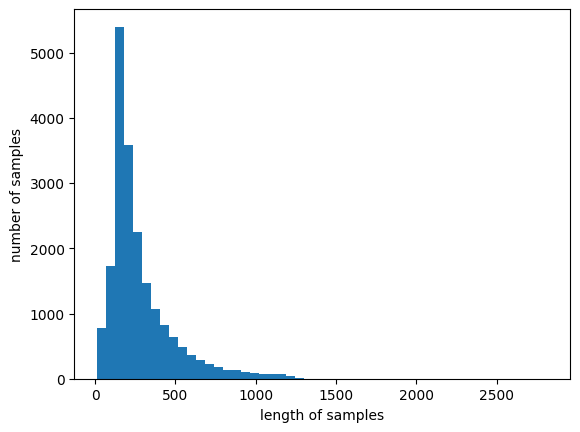

In [27]:
print('Max length :', max(len(review) for review in encoded_X_train))
print('Average length :', sum(map(len, encoded_X_train)) / len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if (len(sentence) <= max_len):
            count += 1
    print('Ratio of samples length below %s : %s' %(max_len, (count / len(nested_list))*100))

In [29]:
max_len = 500
below_threshold_len(max_len, encoded_X_train)

Ratio of samples length below 500 : 87.795


In [32]:
def pad_sequences(sentences, max_len):
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('Shape of train data :', padded_X_train.shape)
print('Shape of valid data :', padded_X_valid.shape)
print('Shape of test data :', padded_X_test.shape)

Shape of train data : (20000, 500)
Shape of valid data : (5000, 500)
Shape of test data : (25000, 500)


##(5) Modeling

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [34]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))

print(train_label_tensor[:5])

tensor([1, 1, 0, 0, 0])


In [35]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length) == (32, 500)
        embedded = self.embedding(x) # (batch_size, seq_length, embedding_dim) == (32, 500, 100)
        gru_out, hidden = self.gru(embedded) # gru_out: (batch_size, seq_length, hidden_dim) / hidden: (1, batch_size, hidden_dim)
        last_hidden = hidden.squeeze(0) # (batch_size, hidden_dim)
        logits = self.fc(last_hidden) # (batch_size, output_dim)
        return logits

In [36]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [37]:
total_batch = len(train_dataloader)
print('Number of total batch : {}'.format(total_batch))

Number of total batch : 625


In [38]:
embedding_dim = 100
hidden_dim = 128
output_dim = 2

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

##(6) Evaluation Function

In [40]:
def calculate_accuracy(logits, labels):
    predicted = torch.argmax(logits, dim=1)
    correct= (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [41]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            logits = model(batch_X)
            loss = criterion(logits, batch_y)

            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

##(7) Training

In [45]:
num_epochs = 5

best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)

        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save Checkpoint
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving checkpoint...')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 0.0204, Train Accuracy: 0.9944
Validation Loss: 0.5625, Validation Accuracy: 0.8714
Validation loss improved from inf to 0.5625. Saving checkpoint...
Epoch 2/5:
Train Loss: 0.0154, Train Accuracy: 0.9960
Validation Loss: 0.6568, Validation Accuracy: 0.8762
Epoch 3/5:
Train Loss: 0.0127, Train Accuracy: 0.9967
Validation Loss: 0.5303, Validation Accuracy: 0.8766
Validation loss improved from 0.5625 to 0.5303. Saving checkpoint...
Epoch 4/5:
Train Loss: 0.0118, Train Accuracy: 0.9970
Validation Loss: 0.5976, Validation Accuracy: 0.8752
Epoch 5/5:
Train Loss: 0.0112, Train Accuracy: 0.9970
Validation Loss: 0.5630, Validation Accuracy: 0.8790


##(8) Model loading and evaluating

In [47]:
model.load_state_dict(torch.load('best_model_checkpoint.pth'))
model.to(device)

TextClassifier(
  (embedding): Embedding(38711, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [48]:
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.5303
Best model validation accuracy: 0.8766


##(9) Model Testing

In [49]:
index_to_tag = {0:'Negative', 1:"Positive"}

def predict(text, model, word_to_index, index_to_tag):
    model.eval()

    # tokenize & encoding. For OOV, assigns <UNK> index 1
    tokens = word_tokenize(text)
    token_indices = [word_to_index.get(token.lower(), 1) for token in tokens]

    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model(input_tensor)

    _, predicted_index = torch.max(logits, dim=1)

    predicted_tag = index_to_tag[predicted_index.item()]
    return predicted_tag

In [50]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

predict(test_input, model, word_to_index, index_to_tag)

'Negative'

In [51]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

predict(test_input, model, word_to_index, index_to_tag)

'Positive'

#[02] 1D CNN

##(1) Modeling

In [52]:
# input.shape == (batch_size, embedding_dim, seq_length)
input = torch.randn(32, 16, 50)

# nn.Conv1d(embedding_dim, # kernels, kernel_size)
m = nn.Conv1d(16, 33, 3, stride=1)

# output.shape == (batch_size, # kernels, vector_size)
output = m(input)
print(output.shape)

torch.Size([32, 33, 48])


In [53]:
class CNN(torch.nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(CNN, self).__init__()

        self.num_filter_sizes = 1
        self.num_filters = 256

        self.word_embed = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=128, padding_idx=0)

        self.conv1 = torch.nn.Conv1d(128, self.num_filters, 5, stride=1)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(1 * self.num_filters, num_labels, bias=True)

    def forward(self, inputs):
        #word_embed(inputs).shape == (batch_size, seq_length, embedding_dim)
        # word_embed(inputs).permute(0, 2, 1).shape == (batch_size, embedding_dim, seq_length)
        embedded = self.word_embed(inputs).permute(0, 2, 1)

        # maxpooling by max
        # conv1(embedded).shape == (batch_size, # kernels, vector_size) == ex) 32, 256, 496
        # conv1(embedded).permute(0, 2, 1).shape == (batch_size, vector_size, # kernels)
        # conv1(embedded).permute(0, 2, 1).max(1)[0].shape == (batch_size, # kernels)
        x = F.relu(self.conv1(embedded).permute(0, 2, 1).max(1)[0])

        # y_pred.shape == (batch_size, # categories)
        y_pred = self.fc1(self.dropout(x))
        return y_pred

In [54]:
model = CNN(vocab_size, num_labels=len(set(y_train)))
model.to(device)

CNN(
  (word_embed): Embedding(38711, 128, padding_idx=0)
  (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

##(2) Traning

In [56]:
num_epochs = 5

best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        logits = model(batch_X)

        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'\nEpoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    print('-' * 99)

    # Save Chekpoint
    if val_loss < best_val_loss:
        print(f'\nValidation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving checkpoint...')
        print('-' * 99)
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch 1/5:
Train Loss: 0.6454, Train Accuracy: 0.6476
Validation Loss: 0.4640, Validation Accuracy: 0.7710
---------------------------------------------------------------------------------------------------

Validation loss improved from inf to 0.4640. Saving checkpoint...
---------------------------------------------------------------------------------------------------

Epoch 2/5:
Train Loss: 0.5034, Train Accuracy: 0.7564
Validation Loss: 0.4261, Validation Accuracy: 0.7994
---------------------------------------------------------------------------------------------------

Validation loss improved from 0.4640 to 0.4261. Saving checkpoint...
---------------------------------------------------------------------------------------------------

Epoch 3/5:
Train Loss: 0.4133, Train Accuracy: 0.8101
Validation Loss: 0.3258, Validation Accuracy: 0.8598
---------------------------------------------------------------------------------------------------

Validation loss improved from 0.4261 t

##(3) Model loading and evaluating

In [57]:
model.load_state_dict(torch.load('best_model_checkpoint.pth'))
model.to(device)

CNN(
  (word_embed): Embedding(38711, 128, padding_idx=0)
  (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [58]:
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.2961
Best model validation accuracy: 0.8788


In [59]:
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.3121
Best model test accuracy: 0.8710


##(4) Model Testing

In [60]:
index_to_tag = {0:'Negative', 1:'Positive'}

def predict(text, model, word_to_index, index_to_tag):
    model.eval()

    tokens = word_tokenize(text)
    token_indices = [word_to_index.get(token.lower(), 1) for token in tokens]

    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model(input_tensor)

        _, predicted_index = torch.max(logits, dim=1)
        predicted_tag = index_to_tag[predicted_index.item()]

        return predicted_tag

In [61]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

predict(test_input, model, word_to_index, index_to_tag)

'Negative'

In [62]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

predict(test_input, model, word_to_index, index_to_tag)

'Positive'

#[03] Pretrained Embedding

##(1) Pretrained Embedding

In [63]:
%%capture
!pip install gensim

In [64]:
%%capture
!pip install gdown
!gdown https://drive.google.com/uc?id=1Av37IVBQAAntSe1X3MOAl5gvowQzd2_j

In [65]:
import gensim

In [66]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',
                                                                 binary=True)

In [69]:
embedding_matrix = np.zeros((vocab_size, 300))

def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

# Except <PAD> 0, <UNK> 1
for word, i in word_to_index.items():
    if i > 1:
        temp = get_vector(word)
        if temp is not None:
            embedding_matrix[i] = temp

In [70]:
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [71]:
word_to_index['apple']

8053

In [72]:
np.all(word2vec_model['apple'] == embedding_matrix[8053])

True

##(2) Modeling

In [73]:
class CNN(torch.nn.Module):
    def __init__(self, vocab_size, num_labels):
        super(CNN, self).__init__()

        self.num_filter_sizes = 1
        self.num_filters = 256

        self.word_embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=300)
        self.word_embed.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.word_embed.weight.requires_grad=True

        self.conv1 = torch.nn.Conv1d(300, self.num_filters, 5, stride=1)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(1 * self.num_filters, num_labels, bias=True)

    def forward(self, inputs):
        embedded = self.word_embed(inputs).permute(0, 2, 1)

        x = F.relu(self.conv1(embedded).permute(0, 2, 1).max(1)[0])

        y_pred = self.fc1(self.dropout(x))

        return y_pred

##(3) Training

In [74]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Save checkpoint
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving checkpoint...')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 0.1555, Train Accuracy: 0.9413
Validation Loss: 0.3301, Validation Accuracy: 0.8730
Validation loss improved from inf to 0.3301. Saving checkpoint...
Epoch 2/5:
Train Loss: 0.1046, Train Accuracy: 0.9601
Validation Loss: 0.3779, Validation Accuracy: 0.8734
Epoch 3/5:
Train Loss: 0.0695, Train Accuracy: 0.9752
Validation Loss: 0.4450, Validation Accuracy: 0.8692
Epoch 4/5:
Train Loss: 0.0512, Train Accuracy: 0.9816
Validation Loss: 0.4911, Validation Accuracy: 0.8740
Epoch 5/5:
Train Loss: 0.0396, Train Accuracy: 0.9864
Validation Loss: 0.5469, Validation Accuracy: 0.8688


##(4) Model loading and evaluating

In [75]:
model.load_state_dict(torch.load('best_model_checkpoint.pth'))
model.to(device)

CNN(
  (word_embed): Embedding(38711, 128, padding_idx=0)
  (conv1): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [76]:
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model validation loss: 0.3301
Best model validation accuracy: 0.8730
Best model test loss: 0.3416
Best model test accuracy: 0.8714


##(5) Model Testing

In [77]:
index_to_tag = {0:'Negative', 1:'Positive'}

def predict(text, model, word_to_index, index_to_tag):
    model.eval()

    tokens = word_tokenize(text)
    token_indices = [word_to_index.get(token.lower(), 1) for token in tokens]

    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model(input_tensor)

        _, predicted_index = torch.max(logits, dim=1)
        predicted_tag = index_to_tag[predicted_index.item()]

        return predicted_tag

In [78]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

predict(test_input, model, word_to_index, index_to_tag)

'Negative'

In [79]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

predict(test_input, model, word_to_index, index_to_tag)

'Positive'